# Принятие решений в бизнесе на основе данных

# Описание проекта

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.


Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

### Описание данных
#### Данные для первой части

Файл `/datasets/hypothesis.csv`
- *Hypothesis* — краткое описание гипотезы;
- *Reach* — охват пользователей по 10-балльной шкале;
- *Impact* — влияние на пользователей по 10-балльной шкале;
- *Confidence* — уверенность в гипотезе по 10-балльной шкале;
- *Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Данные для второй части

Файл `/datasets/orders.csv`
- *transactionId* — идентификатор заказа;
- *visitorId* — идентификатор пользователя, совершившего заказ;
- *date* — дата, когда был совершён заказ;
- *revenue* — выручка заказа;
- *group* — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`
- *date* — дата;
- *group* — группа A/B-теста;
- *visitors* — количество пользователей в указанную дату в указанной группе A/B-теста

### Загрузка и подготовка данных

In [1]:
# Импорт библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150  


hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

# Даем названия датасетам

hypothesis.name, orders.name, visitors.name = 'Гипотезы', 'Заказы', 'Количество пользователей в группе на дату'

#Выводим общую информацию
list = [hypothesis, orders, visitors]
for df in list:
    print ('\033[1m' + 'Датасет:', df.name + '\033[0m')
    display(df.head())
    print()
    print(df.info())
    print()

Датасет: Гипотезы


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

Датасет: Заказы


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None

Датасет: Количество пользователей в группе на дату


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None



Столбцы с датой хорошо бы преобразовать в *datetime*:

In [2]:
#переводим даты в datetime
orders['date'] = pd.to_datetime(orders['date'])
#Проверяем
orders.info()
print()
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим датасеты на дубликаты:

In [3]:
#Проверка на дубликаты:
for df in list:
    print ('\033[1m' + 'Количество дубликатов в датасете:', df.name + '\033[0m')
    print(df.duplicated().sum())
    print()

Количество дубликатов в датасете: Гипотезы
0

Количество дубликатов в датасете: Заказы
0

Количество дубликатов в датасете: Количество пользователей в группе на дату
0



#### Вывод
Пропусков в данных нет, дубликатов нет, даты переведены в datetime. Данные гототы к дальнейшему анализу.

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (нужно доделать)__

А есть ли пользователи, которые попали в две группы теста одновременно?

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Да, такие пользователи нашлись
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

In [4]:
#проверка наличия общих пользователей в группах
bad_users = np.intersect1d(orders.query('group == "A"')['visitorId'].unique(), orders.query('group == "B"')['visitorId'].unique())
bad_users

array([   8300375,  199603092,  232979603,  237748145,  276558944,
        351125977,  393266494,  457167155,  471551937,  477780734,
        818047933,  963407295, 1230306981, 1294878855, 1316129916,
       1333886533, 1404934699, 1602967004, 1614305549, 1648269707,
       1668030113, 1738359350, 1801183820, 1959144690, 2038680547,
       2044997962, 2378935119, 2458001652, 2579882178, 2587333274,
       2600415354, 2654030115, 2686716486, 2712142231, 2716752286,
       2780786433, 2927087541, 2949041841, 2954449915, 3062433592,
       3202540741, 3234906277, 3656415546, 3717692402, 3766097110,
       3803269165, 3891541246, 3941795274, 3951559397, 3957174400,
       3963646447, 3972127743, 3984495233, 4069496402, 4120364173,
       4186807279, 4256040402, 4266935830])

Обновляем таблицу заказов без учета таких пользователей:

In [5]:
orders = orders[~orders['visitorId'].isin(bad_users)]
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1016 non-null int64
visitorId        1016 non-null int64
date             1016 non-null datetime64[ns]
revenue          1016 non-null int64
group            1016 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


### Часть 1. Приоритизация гипотез

In [6]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (можно лучше)__

Чтобы вывести полное название гипотез, можно использовать такой код:  
<code>pd.set_option('display.max_columns', None)  
pd.options.display.max_colwidth = 150  </code>
</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Спасибо, вынес этот код в начало к импорту библиотек
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

#### Фреймворк ICE

__ICE SCORE = (Impact x Confidence) / Efforts__

Добавим столбец ['ICE']

In [7]:
hypothesis['ICE'] = (hypothesis['Impact']*hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis[['Hypothesis','ICE']].sort_values(by = 'ICE', ascending = False).round(0)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (можно лучше)__

В столбце ICE можно было бы округлить данные для красоты.
</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Добавил округление
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

По фреймворку ICE приоритет гипотез:
1. Запустить акцию, дающую скидку на товар в день рождения
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	
5. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

#### Фреймворк RICE

__RICE SCORE = (Reach x Impact x Confidence) / Efforts__

Добавим столбец ['RICE']

In [8]:
hypothesis['RICE'] = (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis[['Hypothesis','RICE']].sort_values(by = 'RICE', ascending = False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По фреймворку RICE приоритет гипотез:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	
5. Запустить акцию, дающую скидку на товар в день рождения

#### Вывод
__Сравнение__

In [9]:
hypothesis[['Hypothesis','RICE','ICE']].sort_values(by = 'RICE', ascending = False)

,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.200000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.333333
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.125000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.333333
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.000000


<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (можно лучше)__

Результаты можно было бы проранжировать и выделить цветом — https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

</div>

Оба фреймворка выделили 5 перспективных гипотез, но в разных порядках:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	
5. Запустить акцию, дающую скидку на товар в день рождения

Так вышло, потому что второй фреймворк использует параметр Reach (охват пользователей). Так гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" оказалось первой, потому что имеет самый большой охват пользователей.

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (нужно переделать)__

В целом раздел сделан хорошо, только несколько странно, что ты коллегам/руководству пишешь номера гипотез, почему не полные названия? Так им не придется искать где гипотезы записаны. Они у них вообще могут быть без номеров и в другой сортировке. У тебя же номера гипотез получены просто после импорта в pandas.

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Поправил. Отказался от использования индекса
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

### Часть 2. Анализ A/B-теста

#### 1. График кумулятивной выручки по группам

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [11]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1
).sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [12]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1
).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [13]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


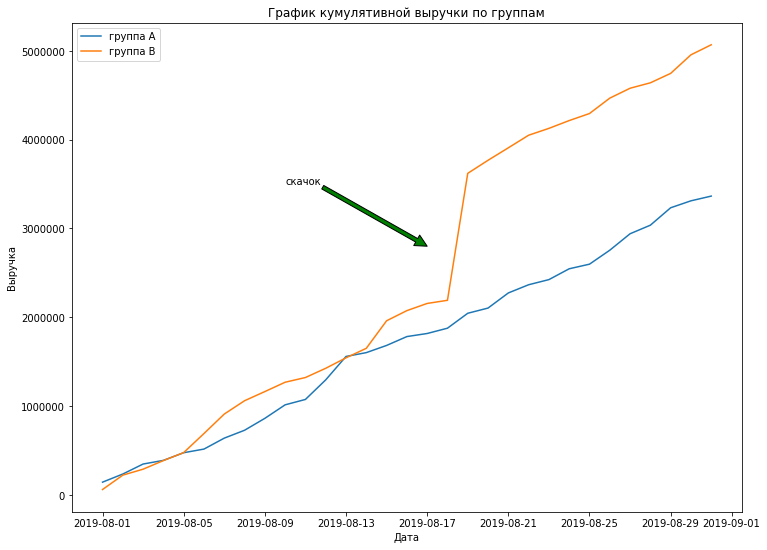

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12, 9))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='группа A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='группа B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка') 
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.legend();

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (нужно доделать)__

Проверь, пожалуйста, на всех графиках в проекте наличие заголовков и подписей осей. Не забудь давать заголовкам и подписям осознанные и понятные значения с указанием размерности (шт., млн. и т.д.). Желательно, чтобы заголовок и название осей были на одном языке.

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Поправил.
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

На всем периоде проведения теста, значения Сегмента В лежат выше значений А. 18-08-2019 произошел резкий скачек выручки, возможно это аномально большая сумма заказа отразилась

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (можно лучше)__

На график можно было добавить аннотации для наглядности через такой код:  
<code>plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) </code>
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

#### 2. График кумулятивного среднего чека по группам

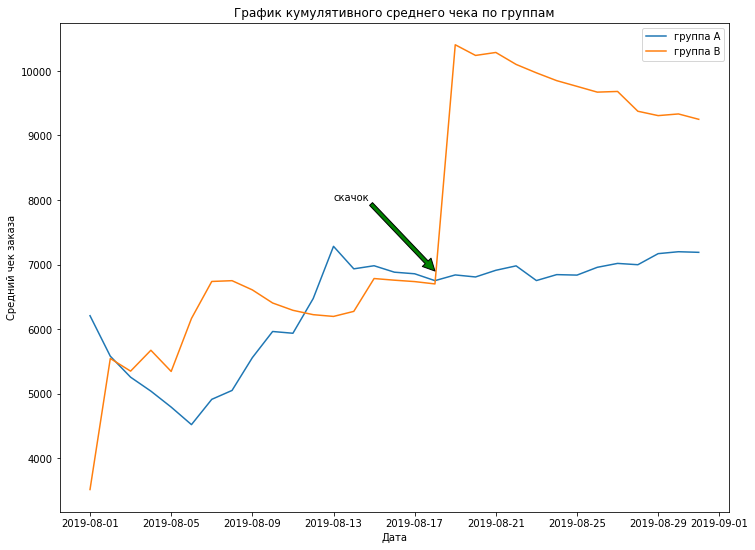

In [15]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']]

plt.figure(figsize=(12, 9))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='группа B')


plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек заказа') 
plt.annotate('скачок', xy=('2019-08-18', 6900), xytext=('2019-08-13', 8000),
            arrowprops=dict(facecolor='g'))

plt.legend();

Графики кумулятывных чеков для обоих сегментов колеблются. Так же виден большой скачек 18 августа, за счет котого средний чек группы В оказался выше.

#### 3. График относительного изменения кумулятивного среднего чека группы B к группе A

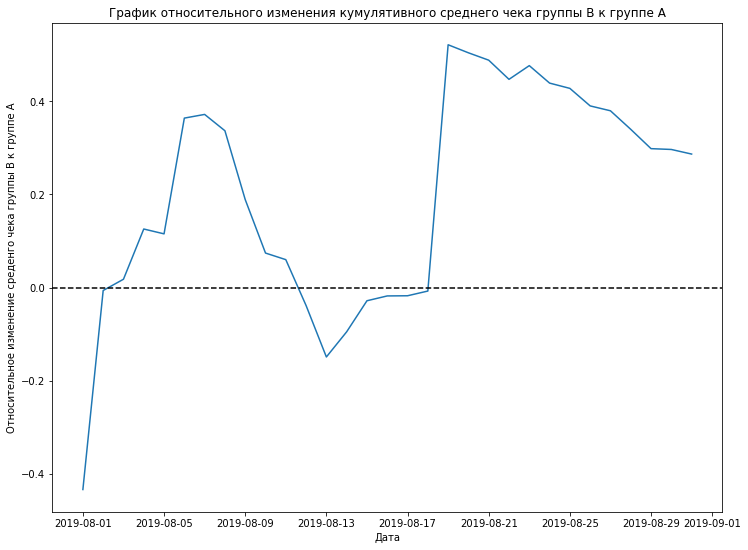

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 9))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среденго чека группы В к группе А') 
plt.axhline(y=0, color='black', linestyle='--');

График относительного изменения кумулятивного среднего чека так же ведет себя скачкообразно. Есть периоды дат, где средний чек группы А больше.

#### 4. График кумулятивной конверсии по группам

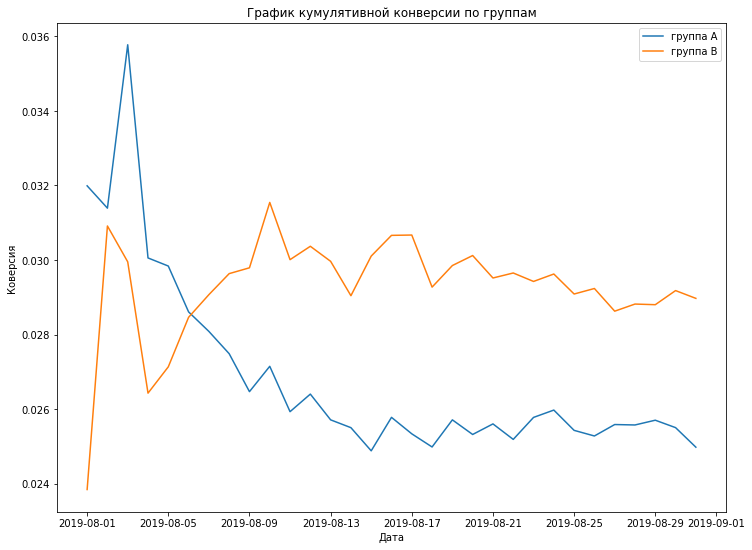

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 9))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='группа B')

plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Коверсия') 

plt.legend();

В начале теста конверсия группы A была больше, но после 6 августа конверсия группы В вышла вперед.

#### 5. График относительного изменения кумулятивной конверсии группы B к группе A

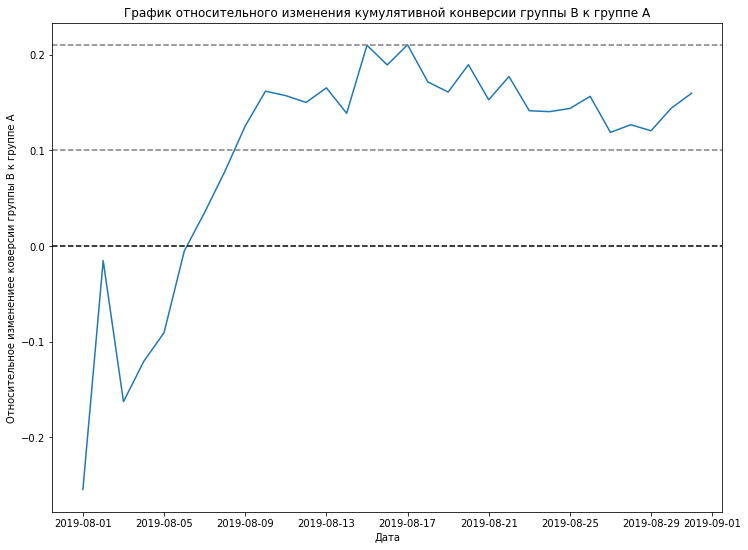

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 9))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменениее коверсии группы В к группе А') 
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='gray', linestyle='--')
plt.axhline(y=0.21, color='gray', linestyle='--');

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (можно лучше)__

Тут легенда на графике выглядят лишней, у нас же нет разделения данных на категории.
</div>

После 6 августа конверсия группы B опережает коверсию группы А, но прирост колеблется в пределах 10% и 21%.

#### 6. График количества заказов по пользователям

In [19]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId' : pd.Series.nunique})
)
ordersByUsers.columns = ['userId', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


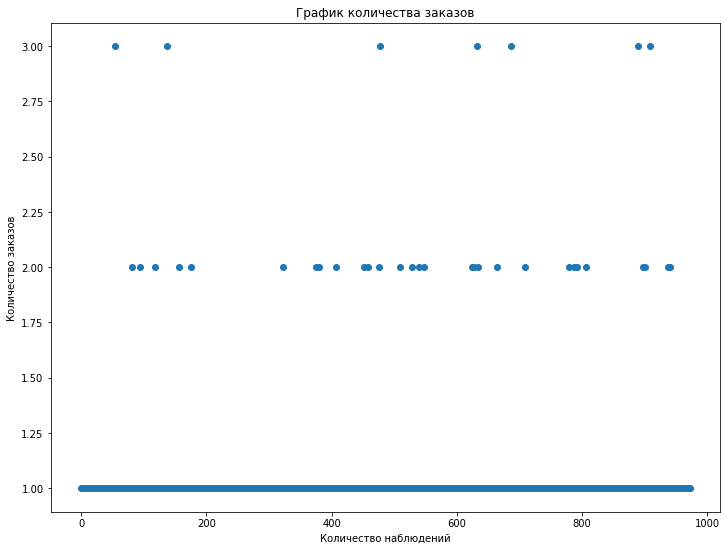

In [20]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(12, 9))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов')
plt.xlabel('Количество наблюдений')
plt.ylabel('Количество заказов');

Пользователей, заказавших больше 2 раз не так много. Надо посмотреть перцентили.

*После удаления пользователей,которые находились в двух группах одновременно, разброс по количеству заказов поуменьшился*

#### 7. Рассчет перцентелей заказов

In [21]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 1. 2.]


95% пользователей заказывают не более одного раза. И не более 1% - больше 2 заказов.

#### 8. График стоимостей заказов

In [22]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A
949,1347999392,887908475,2019-08-21,60450,A
940,2420050534,4003628586,2019-08-08,58550,B
131,3163614039,2254586615,2019-08-22,53904,A


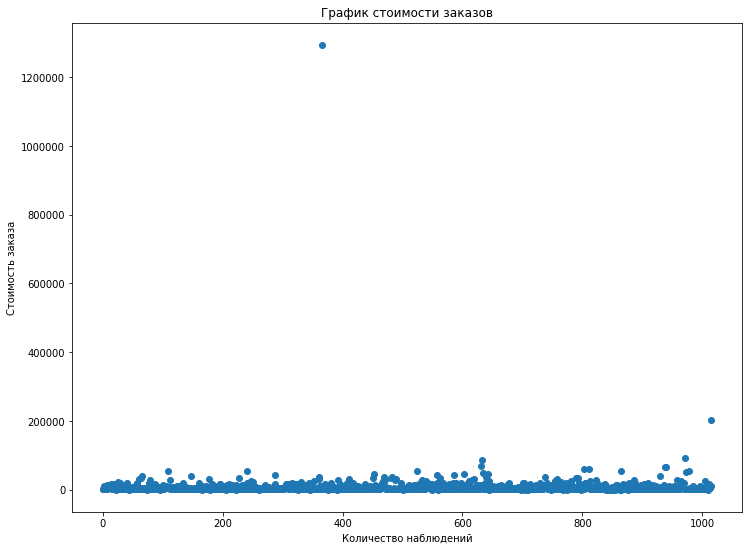

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12, 9))
plt.scatter(x_values, orders['revenue'])
plt.title('График стоимости заказов')
plt.xlabel('Количество наблюдений')
plt.ylabel('Стоимость заказа');

На графике видны выбросы: более 1,2М, 200 тыс, около 100 тысяч. Опять же, посмотрим перцентили распределения.

#### 9. Рассчет перцентелей стоимости заказов

In [24]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

Не более, чем у 5% заказов чек дороже 26785, не более чем у 1% заказов - дороже 53904.

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №1 (OK)__

Аномальные значения найдены верно.
</div>

#### 10. Статистическая значимость различий в конверсии между группами по «сырым» данным

Подготовим данные

In [25]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [26]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA.head()

,userId,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [27]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB.head()

,userId,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [28]:
#Объявим переменные sampleA и sampleB, 
#в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (нужно доделать)__

Нужно сформулировать гипотезы перед каждым тестом, иначе что мы проверяем? Примерно так:  
1. Нулевая гипотеза: ...  
2. Обратная гипотеза: ...  
    
Так сторонний наблюдатель поймет что ты проверяешь.
    
А вот в [этой статье](https://ru.qwe.wiki/wiki/Null_hypothesis) можно почитать в целом о формулировании гипотез и как всё это дело началось)

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Поправил.
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

__Нулевая гипотеза__: Статистически значимых различий в конверсии между группами нет.<br>
__Альтернативная гипотеза__: Между группами есть статистически значимые различия в конверсии.

In [29]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.5f}".format(sampleB.mean() / sampleA.mean() - 1))

0.00551
0.15980


<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (можно лучше)__

Все импорты, по стандарту оформления кода pep8, принято выносить в начало работы — https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#id8

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Вынес все импорты в начало
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

##### Вывод по "сырым" данным
`p-value = 0.00551` меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем.  

Относительный выигрыш группы B равен 15.98%

#### 11. Статистическая значимость различий в среднем чеке между группами по «сырым» данным

__Нулевая гипотеза__: Статистически значимых различий в среднем чеке между группами по «сырым» данным нет.<br>
__Альтернативная гипотеза__: Между группами есть статистически значимые различия в среднем чеке по «сырым» данным.

In [30]:
print('{0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.5f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.41475
0.28660


##### Вывод по "сырым" данным
`p-value = 0.41475` больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.  

При этом средний чек группы В выше на 28.66%

#### 12. Статистическая значимость различий в конверсии между группами по «очищенным» данным

Очистим данные от аномалий

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000.

In [31]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.shape) 

(55,)


Получили 55 аномальных пользователей

In [32]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

__Нулевая гипотеза__: Статистически значимых различий в конверсии между группами по "очищенным" данным нет.<br>
__Альтернативная гипотеза__: Между группами есть статистически значимые различия в конверсии по "очищенным" данным.

In [33]:
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.5f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00473
0.18863


##### Вывод по "очищенным" данным
`p-value = 0.00402` меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем.  

Относительный выигрыш группы B равен 18.86%

#### 13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [34]:
print(
    '{0:.5f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.5f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.38084
-0.02245


##### Вывод по "очищенным" данным
`p-value = 0.38084` больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.  

При этом средний чек группы В ниже на 2.24%

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (нужно доделать)__

А вот тут как-то странно получилось, ты же удаляешь все аномалии, а разница в среднем чеке почти не меняется.

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Нашлась опечатка при формировании abnormalUsers
</div>

<div class="alert alert-block alert-success">
    

__Комментарий от ревьюера №2 (OK)__

👍
</div>

#### 14. Результат теста

- Есть статистические значимые различия в конверсии между группами А и В, как по "сырым", так и по "очищенным" данным. Относительный выиигрыш группы B в конверсии - 15.98% (по сырым) и 18.86% (по очищенным)

- Нет статистически значимых различий в среднем чеке заказа между группами А и В как по "сырым", так и по "очищенным" данным. При этом средний чек группы B по очищенным данным оказался нижне на 2.24%.

- График относительного различия кумулятивной конверсий сообщает, что группа В оказалось лучше группы А.

- График относительного различия кумулятивного среднего чека также сообщает, что группа В оказалось лучше группы А.

- Остановить тест, зафиксировать победу группы В. 

<div class="alert alert-block alert-warning">
    

__Комментарий от ревьюера №1 (нужно доделать)__

Напиши, пожалуйста, общий вывод к проекту, который будет включать этапы предобработки данных, приоритезации гипотез, анализа данных и А/Б-теста.

</div>

<div style="border-radius: 15px; border: solid blue 2px; padding: 20px">
<b>Комментарий от студента №1</b><br>
Добавил
</div>

## Общий вывод

__Этап предобработки данных__<br>
На этапе предобработки данных были выявлены пользователи, находящиеся одновременно в двух группах. Таблица заказов была скорректирована

__Приоритезации гипотез__<br>
По фреймворку RICE приоритет гипотез следующий:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
5. Запустить акцию, дающую скидку на товар в день рождения

__Анализ данных__<br>
В ходе изучения заказов и стоимости были выявлены аномальные пользователи.<br>
По количеству заказов: 95% пользователей заказывают не более одного раза. И не более 1% - больше 2 заказов.<br>
По стоимости заказа: не более, чем у 5% заказов чек дороже 26785, не более чем у 1% заказов - дороже 53904.

__Результат A/B-теста__<br>

1. Есть статистически значимые различия в конверсии между группами А и В, как по "сырым", так и по "очищенным" данным. Относительный выиигрыш группы B в конверсии - 15.98% (по сырым) и 18.86% (по очищенным)
2. Нет статистически значимых различий в среднем чеке заказа между группами А и В как по "сырым", так и по "очищенным" данным. При этом средний чек группы B по очищенным данным оказался нижне на 2.24%.
3. Остановить тест, зафиксировать победу группы В

<div class="alert alert-block alert-success">

__Комментарий от ревьюера по общему выводу №1 (OK)__ 

Что сделано хорошо:  
— есть информация о проблемах в данных;   
— представлены основные выводы с этапов анализа;  
— выделены основные гипотезы для проверки;  
— есть вывод про А/Б-тест и победившую группу.  

Что можно было сделать лучше:  
— предположить что победа группы B даст продукту в целом (средний чек не упал, но конверсия выросла, значит количество заказов тоже будет больше).
</div>